In [18]:
import os
!pip install fasttext
import fasttext
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import xml.etree.ElementTree as ET
from IPython.display import clear_output

!pip install nltk
import nltk
nltk.download('punkt')
clear_output()

if not os.path.exists("articles/"):
  !wget https://zenodo.org/record/1239675/files/articles.zip?download=1 -O articles.zip
  !unzip articles.zip
  !rm articles.zip
  clear_output()
  print("Data successfully downloaded")
else:
  print("Data already downloaded")

random_seed = 176249

Data already downloaded


In [59]:
def read_data(test_size=0.2,random_state=0):
  data = {
      # "author": [],
      # "title": [],
      "mainText": [],
      "orientation": [],
      # "veracity": []
  }
  index = []
  for filename in os.listdir("articles/"):
    root = ET.parse(f"articles/{filename}").getroot()
    index.append(int(filename.split(".")[0]))
    for elem in root:
      if elem.tag in data.keys():
        data[elem.tag].append(elem.text)
  data = pd.DataFrame(data,index=index)
  data = data[data.notna().all(axis="columns")]
  data = data.sample(frac=1,random_state=random_state)
  N = len(data)
  train_split, test_split = data.iloc[int(N*test_size):,:], data.iloc[:int(N*test_size),:]
  train_split = train_split.reset_index(drop=True)
  test_split = test_split.reset_index(drop=True)
  return train_split, test_split
  
train_split, test_split = read_data(test_size=0.2,random_state=random_seed)
train_split

,mainText,orientation
0,The Republican candidate's campaign launched a...,mainstream
1,Washington (CNN)Spending by super PACs tied to...,mainstream
2,Mike Pence defended his running mate Donald Tr...,mainstream
3,Hillary Clinton has added her name to the grow...,mainstream
4,Hillary Clinton’s nationwide lead over Donald ...,mainstream
...,...,...
1279,(CNN)President Barack Obama and Vice President...,mainstream
1280,Explore topics and guests discussed in this ep...,mainstream
1281,As idiots like Colin Kaepernick took a knee to...,right
1282,(CNN)President Barack Obama sharply criticized...,mainstream


In [68]:
def normalize_text(corpus,stop_words=None):

  # Convierto a lowercase
  corpus_lower = corpus.str.lower()

  # Elimino signos de puntuación, caracteres raros, etc.
  normalized_corpus = corpus_lower.str.replace(r"[^\w\d\s]+","",regex=True)

  # Elimino los stopwords
  if stop_words is not None:
    stop_words = "|".join(stop_words)
    normalized_corpus = normalized_corpus.str.replace(stop_words,"",regex=True)

  # Elimino espacios innecesarios
  normalized_corpus = normalized_corpus.str.replace(r"\s+"," ",regex=True)

  return normalized_corpus

train_data, test_data = read_data(test_size=0.2,random_state=random_seed)
train_data["mainText"] = normalize_text(train_data["mainText"],stop_words=["the ","to ","and ","of ","a ","in ","that","for ","on ","this","at ","on ", "is ", "it "])
train_data

,mainText,orientation
0,republican candidates campaign launched nation...,mainstream
1,washingtcnnspending by super pacs tied donald ...,mainstream
2,mike pence defended hrunning mate donald trump...,mainstream
3,hillary clinthas added her name growing list p...,mainstream
4,hillary clintons nationwide lead over donald t...,mainstream
...,...,...
1279,cnnpresident barack obamvice president joe bid...,mainstream
1280,explore topics guests discussed episode kevmad...,mainstream
1281,as idiots like colkaepernick took knee protest...,right
1282,cnnpresident barack obamsharply criticized rep...,mainstream


In [69]:
train_data_array = pd.DataFrame.to_numpy(train_data)

In [70]:
train_data_array[:,1]
mainstream_filter = np.where(train_data_array[:,1] == 'mainstream')
right_filter = np.where(train_data_array[:,1] == 'right')
left_filter = np.where(train_data_array[:,1] == 'left')

mainstream_news = train_data_array[mainstream_filter]
right_news = train_data_array[right_filter]
left_news = train_data_array[left_filter]

100%|██████████| 2/2 [00:00<00:00, 535.33it/s]


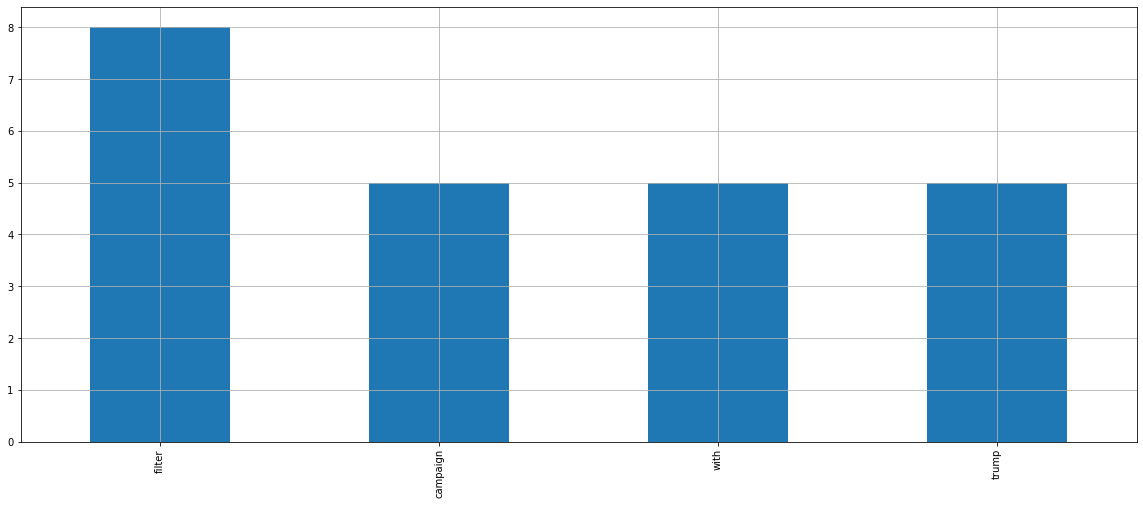

In [71]:
#veo las palabras mas repetidas segun la orientacion politica de los articulos
from nltk import word_tokenize
from collections import defaultdict

def create_vocabulary(corpus,tokenizer,max_tokens=40000,min_freq=1):
  counts = defaultdict(lambda: 0)
  for comment in tqdm(corpus):
    for token in tokenizer(comment):
      counts[token] += 1

  valid_tokens = sorted([tk for tk in counts.keys() if counts[tk] >= min_freq],key=counts.get,reverse=True)[:max_tokens]
  counts = [counts[tk] for tk in valid_tokens]
  return pd.Series(counts,index=valid_tokens)

vocab = create_vocabulary(mainstream_news[0],word_tokenize,max_tokens=10000,min_freq=5)

fig, ax = plt.subplots(1,1,figsize=(20,8))
vocab[:100].plot(kind="bar",ax=ax,fontsize=10)
ax.grid(True)

100%|██████████| 2/2 [00:00<00:00, 1088.30it/s]


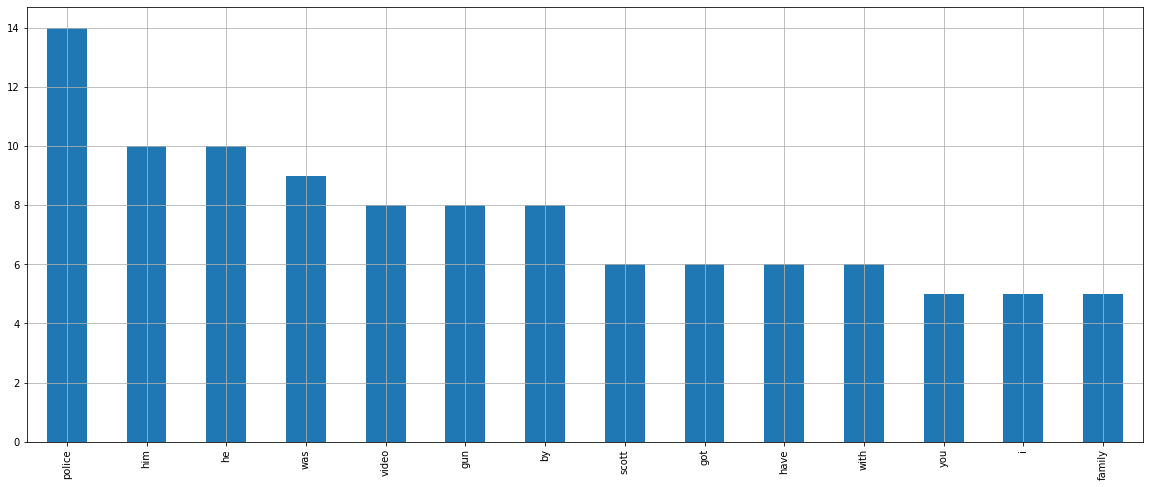

In [72]:
vocab2 = create_vocabulary(right_news[0],word_tokenize,max_tokens=10000,min_freq=5)

fig, ax = plt.subplots(1,1,figsize=(20,8))
vocab2[:100].plot(kind="bar",ax=ax,fontsize=10)
ax.grid(True)

100%|██████████| 2/2 [00:00<00:00, 305.50it/s]


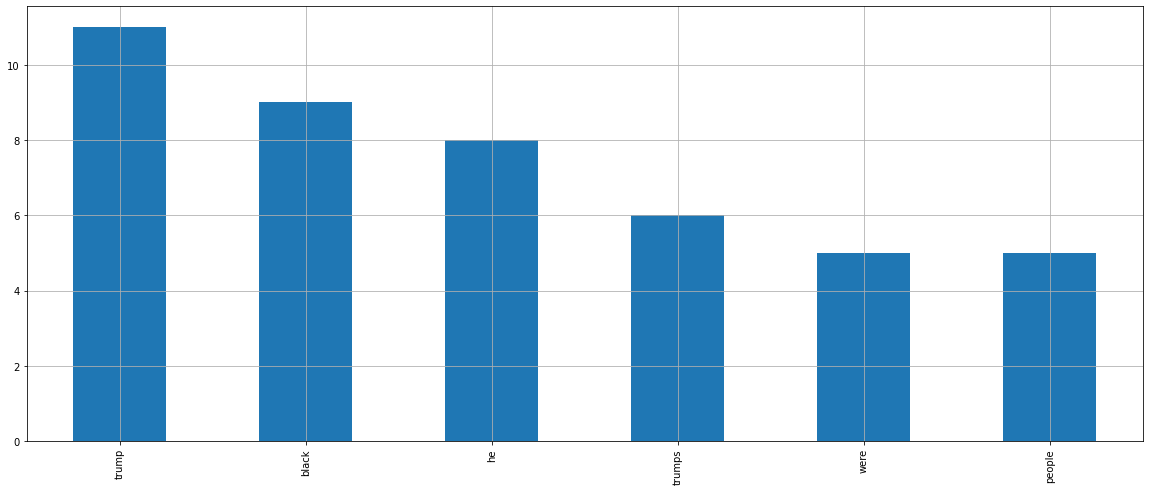

In [73]:
vocab3 = create_vocabulary(left_news[0],word_tokenize,max_tokens=10000,min_freq=5)

fig, ax = plt.subplots(1,1,figsize=(20,8))
vocab3[:100].plot(kind="bar",ax=ax,fontsize=10)
ax.grid(True)

In [74]:
def vectorize(corpus,tokenizer,vocab):
  N = len(vocab)
  corpus_size = len(corpus)
  X = np.zeros((len(corpus),N))

  token2idx = {tk: i for i, tk in enumerate(vocab.index)}
  for i, article in enumerate(tqdm(corpus)):
    for w in tokenizer(article):
      if w in vocab.index:
        idx = token2idx[w]
        X[i,idx] += 1
  
  return X

In [75]:
import tensorflow as tf 

In [76]:
#BOW + clasificador softmax


def get_and_bow_vectorize_data(
    stop_words=None,
    max_tokens=10000,
    min_freq=1
):

  train_data, test_data = read_data()
  train_data["mainText"] = normalize_text(train_data["mainText"],stop_words=stop_words)
  test_data["mainText"] = normalize_text(test_data["mainText"],stop_words=stop_words)

  vocab = create_vocabulary(train_data["mainText"],word_tokenize,max_tokens=max_tokens,min_freq=min_freq)
  X_train = vectorize(train_data["mainText"],word_tokenize,vocab)
  y_train = train_data["orientation"].map({"mainstream": 0, "right": 1, "left": 2})

  X_test = vectorize(test_data["mainText"],word_tokenize,vocab)
  y_test = test_data["orientation"].map({"mainstream": 0, "right": 1, "left": 2})

  return X_train, y_train, X_test, y_test

# Leo y vectorizo las noticias
X_train, y_train, X_test, y_test = get_and_bow_vectorize_data(stop_words=["the ","to ","and ","of ","a ","in ","that","for ","on ","this","at ","on ", "is ", "it "])

# Softmax Classifier
model = tf.keras.Sequential() 
model.add(tf.keras.layers.Dense(3, input_dim=np.shape(X_train)[1])) 
model.summary() 
es = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=1) 
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-2), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True), metrics = 'accuracy') 
hist = model.fit(x= X_train, y= y_train, batch_size = np.size(y_train), epochs=2000, callbacks=[es])

100%|██████████| 320/320 [00:00<00:00, 463.94it/s]


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 3)                 30003     
                                                                 
Total params: 30,003
Trainable params: 30,003
Non-trainable params: 0
_________________________________________________________________
Epoch 1/2000
1/1 [==============================] - 1s 769ms/step - loss: 1.1235 - accuracy: 0.3396
Epoch 2/2000
1/1 [==============================] - 0s 69ms/step - loss: 0.9919 - accuracy: 0.5039
Epoch 3/2000
1/1 [==============================] - 0s 66ms/step - loss: 0.9558 - accuracy: 0.5109
Epoch 4/2000
1/1 [==============================] - 0s 62ms/step - loss: 0.9279 - accuracy: 0.5413
Epoch 5/2000
1/1 [==============================] - 0s 66ms/step - loss: 0.9035 - accuracy: 0.5646
Epoch 6/2000
1/1 [==============================] - 0s 70ms/step - loss: 0.8817 - ac

10/10 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.47      1.00      0.64       151
           1       0.00      0.00      0.00       119
           2       0.00      0.00      0.00        50

    accuracy                           0.47       320
   macro avg       0.16      0.33      0.21       320
weighted avg       0.22      0.47      0.30       320



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


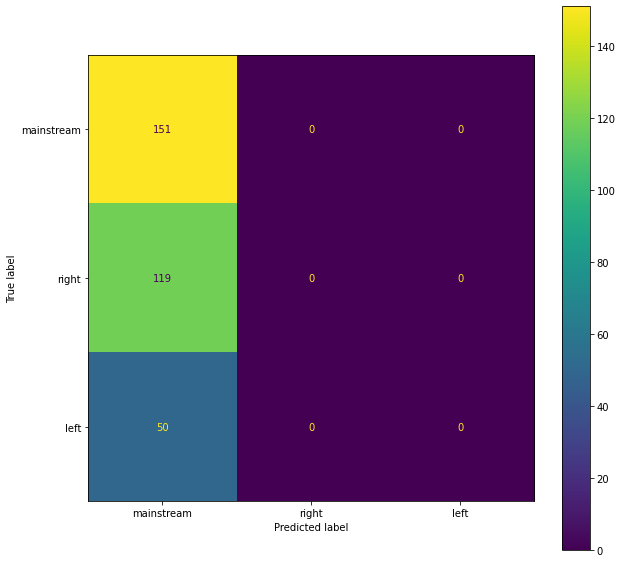

In [134]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

def show_results(y_true,y_pred):

  fig, ax = plt.subplots(1,1,figsize=(10,10))
  dsp = ConfusionMatrixDisplay.from_predictions(y_true,y_pred,display_labels=["mainstream", "right", "left"],ax=ax)
  print(classification_report(y_true,y_pred))

y_df = pd.DataFrame(y_test)
y_test_array = pd.DataFrame.to_numpy(y_df)
y_predict = model.predict(X_test)

results = np.zeros((np.shape(y_predict)[0],1))
for x in np.arange(np.shape(results)[0]):
  results[x] = np.argmax(y_predict[x])
results = results.astype(int)

show_results(y_test_array, results)

In [137]:
# Features selection

def get_data_and_select_keywords(
    stop_words=None, 
):

  train_data, test_data = read_data()
  train_data["mainText"] = normalize_text(train_data["mainText"],stop_words=stop_words)
  test_data["mainText"] = normalize_text(test_data["mainText"],stop_words=stop_words)

  #utilizo palabras vistas anteriormente mas algunas que supongo que son claves 
  vocab = {'trump', 'obama', 'peace', 'gun', 'black', 'white', 'police', 'people', 'familiy', 'campaign', 'him', 'her'}
  vocab_df = pd.DataFrame(vocab)

  X_train = vectorize(train_data["mainText"],word_tokenize,vocab_df)
  y_train = train_data["orientation"].map({"mainstream": 0, "right": 1, "left": 2})

  X_test = vectorize(test_data["mainText"],word_tokenize,vocab_df)
  y_test = test_data["orientation"].map({"mainstream": 0, "right": 1, "left": 2})

  return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = get_data_and_select_keywords(stop_words=["the ","to ","and ","of ","a ","in ","that","for ","on ","this","at ","on ", "is ", "it "])


model = tf.keras.Sequential() 
model.add(tf.keras.layers.Dense(3, input_dim=np.shape(X_train)[1])) 
model.summary() 
es = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=1) 
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-2), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True), metrics = 'accuracy') 
hist = model.fit(x= X_train, y= y_train, batch_size = np.size(y_train), epochs=2000, callbacks=[es])

100%|██████████| 320/320 [00:00<00:00, 351.02it/s]

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 3)                 39        
                                                                 
Total params: 39
Trainable params: 39
Non-trainable params: 0
_________________________________________________________________


Epoch 1/2000
1/1 [==============================] - 0s 280ms/step - loss: 1.0986 - accuracy: 0.5226
Epoch 2/2000
1/1 [==============================] - 0s 12ms/step - loss: 1.0979 - accuracy: 0.5226
Epoch 3/2000
1/1 [==============================] - 0s 12ms/step - loss: 1.0973 - accuracy: 0.5226
Epoch 4/2000
1/1 [==============================] - 0s 9ms/step - loss: 1.0966 - accuracy: 0.5226
Epoch 5/2000
1/1 [==============================] - 0s 10ms/step - loss: 1.0960 - accuracy: 0.5226
Epoch 6/2000
1/1 [==============================] - 0s 14ms/step - loss: 1.0953 - accuracy: 0.5226
Epoch 7/2000
1/1 [==============================] - 0s 9ms/step - loss: 1.0947 - accuracy: 0.5226
Epoch 8/2000
1/1 [==============================] - 0s 9ms/step - loss: 1.0940 - accuracy: 0.5226
Epoch 9/2000
1/1 [==============================] - 0s 9ms/step - loss: 1.0934 - accuracy: 0.5226
Epoch 10/2000
1/1 [==============================] - 0s 9ms/step - loss: 1.0928 - accuracy: 0.5226
Epoch 11/2000

10/10 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.47      1.00      0.64       151
           1       0.00      0.00      0.00       119
           2       0.00      0.00      0.00        50

    accuracy                           0.47       320
   macro avg       0.16      0.33      0.21       320
weighted avg       0.22      0.47      0.30       320



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


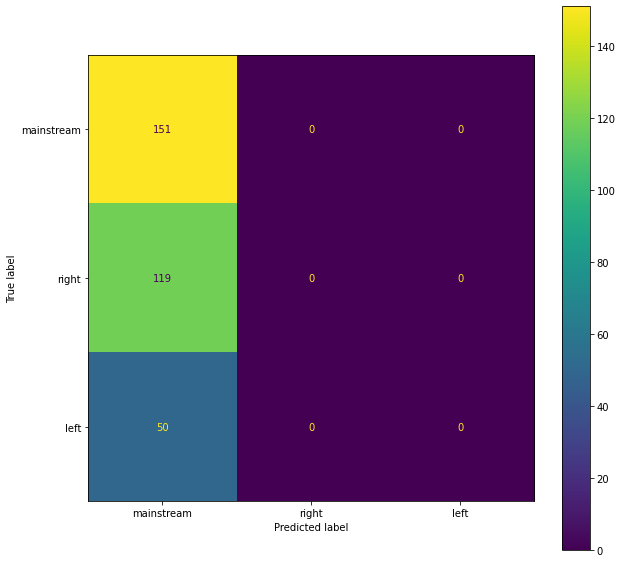

In [138]:
#no es facil encontrar el vocabulario adecuado para clasificar 
y_df = pd.DataFrame(y_test)
y_test_array = pd.DataFrame.to_numpy(y_df)
y_predict = model.predict(X_test)

results = np.zeros((np.shape(y_predict)[0],1))
for x in np.arange(np.shape(results)[0]):
  results[x] = np.argmax(y_predict[x])
results = results.astype(int)

show_results(y_test_array, results)